# Previsão de Consumo de Energia Elétrica no Brasil com LSTM

## Introdução

Neste projeto, implementaremos uma solução de Redes Neurais Recorrentes (RNN) utilizando a arquitetura LSTM (Long Short-Term Memory) para prever o consumo de energia elétrica no Brasil. O modelo será treinado com dados fictícios de cinco estados brasileiros e realizará previsões para os próximos 12 meses.

### Objetivos do Projeto:
1. Criar um dataset representando o consumo mensal de energia elétrica por estado.
2. Comparar o consumo de energia elétrica entre estados brasileiros com uma análise exploratória.
3. Tratar os dados para entrada no modelo, incluindo normalização e divisão em treino e teste.
4. Desenvolver e treinar um modelo LSTM para previsão de consumo energético.
5. Realizar previsões para os próximos 12 meses e avaliar o desempenho do modelo.
6. Visualizar os resultados com gráficos detalhados.

---

## Geração do Dataset

Os dados utilizados foram gerados artificialmente para simular o consumo mensal de energia elétrica em diferentes estados brasileiros entre janeiro de 2020 e dezembro de 2023.

### Estrutura do Dataset:
- **Data**: Período (ano e mês).
- **SP, RJ, MG, RS, BA**: Consumo mensal de energia elétrica em kWh para os estados de São Paulo, Rio de Janeiro, Minas Gerais, Rio Grande do Sul e Bahia.

Os valores foram gerados utilizando intervalos realistas de consumo por estado.

In [ ]:
# Importações necessárias para a geração do dataset
import pandas as pd
import numpy as np
import os

# Definir seeds para reprodutibilidade dos resultados
SEED = 42
np.random.seed(SEED)

# Criar diretórios 'data' e 'images' se não existirem
os.makedirs('/content/data', exist_ok=True)
os.makedirs('/content/images', exist_ok=True)

def gerar_dados_consumo():
    """
    Gera dados fictícios de consumo de energia elétrica para estados brasileiros.

    Retorna:
        pd.DataFrame: Dataset com consumo mensal de energia por estado.
    """
    # Gerar uma sequência de datas de janeiro de 2020 a dezembro de 2023
    datas = pd.date_range(start='2020-01-01', end='2023-12-01', freq='MS')

    # Criar dados fictícios de consumo para cada estado
    consumo = {
        'Data': datas,
        'SP': np.random.uniform(2000, 5000, len(datas)),  # Consumo entre 2000 e 5000 kWh
        'RJ': np.random.uniform(1500, 4000, len(datas)),  # Consumo entre 1500 e 4000 kWh
        'MG': np.random.uniform(1800, 4500, len(datas)),  # Consumo entre 1800 e 4500 kWh
        'RS': np.random.uniform(1200, 3000, len(datas)),  # Consumo entre 1200 e 3000 kWh
        'BA': np.random.uniform(1000, 3500, len(datas))   # Consumo entre 1000 e 3500 kWh
    }

    # Converter o dicionário para um DataFrame
    df = pd.DataFrame(consumo)
    df['Data'] = df['Data'].dt.strftime('%Y-%m')  # Formatar a data como ano-mês
    return df

# Gerar o dataset
dataset_consumo = gerar_dados_consumo()

# Salvar o dataset em um arquivo CSV na pasta 'data'
dataset_consumo.to_csv('/content/data/consumo_energia_estados.csv', index=False)

# Visualizar as primeiras linhas do dataset
print(dataset_consumo.head())

      Data           SP           RJ           MG           RS           BA
0  2020-01  3123.620357  2866.775698  3211.378639  1712.712890  3251.045143
1  2020-02  4852.142919  1962.136139  2954.360750  1266.396505  2582.753643
2  2020-03  4195.981825  3923.961569  1868.631642  2297.215801  1847.574478
3  2020-04  3795.975453  3437.832058  2091.306853  2104.822242  1873.023937
4  2020-05  2468.055921  3848.747354  1884.858801  1292.661752  2814.889197


## Carregamento e Pré-Processamento dos Dados
Após a geração do dataset, realizamos:

1. Carregamento do Dataset:
* Carregamos o arquivo CSV gerado para análise.

2. Normalização dos Dados:
* Cada estado é normalizado individualmente utilizando MinMaxScaler.

3. Separação dos Dados:
* Dividimos os dados em conjunto de treino (70%) e teste (30%).
* A divisão garante registros suficientes no conjunto de teste para criar   sequências.

## Objetivo:
Preparar os dados para entrada no modelo LSTM, garantindo consistência e normalização individualizada.

In [ ]:
# Importações necessárias para o pré-processamento
from sklearn.preprocessing import MinMaxScaler

# Carregar o dataset salvo
dados = pd.read_csv('/content/data/consumo_energia_estados.csv')

def preprocessar_dados_por_estado(dados):
    """
    Normaliza os dados de consumo de energia para cada estado individualmente.

    Args:
        dados (pd.DataFrame): Dataset bruto.

    Returns:
        pd.DataFrame: Dataset normalizado.
        dict: Dicionário contendo o scaler para cada estado.
    """
    scalers = {}
    dados_normalizados = dados.copy()

    # Normalizar cada coluna (exceto 'Data') separadamente
    for coluna in dados.columns[1:]:
        scaler = MinMaxScaler()
        dados_normalizados[coluna] = scaler.fit_transform(dados[[coluna]])
        scalers[coluna] = scaler

    return dados_normalizados, scalers

# Aplicar o pré-processamento
dados_normalizados, scalers = preprocessar_dados_por_estado(dados)

# Dividir os dados em treino e teste (70% treino, 30% teste)
dados_treino = dados_normalizados.iloc[:int(len(dados_normalizados) * 0.7), :]
dados_teste = dados_normalizados.iloc[int(len(dados_normalizados) * 0.7):, :]

# Visualizar os primeiros registros do dataset normalizado
print(dados_normalizados.head())

      Data        SP        RJ        MG        RS        BA
0  2020-01  0.372850  0.551465  0.534582  0.276817  0.925004
1  2020-02  0.979780  0.182738  0.435920  0.020947  0.648836
2  2020-03  0.749384  0.982369  0.019140  0.611907  0.345027
3  2020-04  0.608931  0.784225  0.104619  0.501610  0.355544
4  2020-05  0.142664  0.951712  0.025369  0.036005  0.744765


## Análise Exploratória dos Dados (EDA)

A análise exploratória permite identificar padrões de consumo entre os estados ao longo do tempo. Para isso, geramos um gráfico comparativo do consumo normalizado de energia por estado.

### Ajustes Realizados:
1. **Conversão de Data:** A coluna `Data` foi convertida para o tipo datetime para garantir consistência no eixo X.
2. **Gráfico Comparativo por Estado:** Cada estado foi tratado individualmente, e iteramos sobre as colunas correspondentes para criar uma visualização clara.
3. **Legibilidade do Gráfico:** Ajustamos a rotação dos rótulos do eixo X e ativamos a grade para melhorar a interpretação.

O gráfico resultante apresenta os padrões de consumo de energia por estado ao longo do tempo, permitindo identificar tendências regionais e variações no consumo.

### Análise:

1. SP (São Paulo): Consumo estável com pequenas variações mensais.
2. RJ (Rio de Janeiro): Picos de consumo em determinados meses, possivelmente relacionados a eventos sazonais.
3. MG (Minas Gerais): Consumo crescente ao longo dos anos, indicando possível aumento populacional ou industrial.
4. RS (Rio Grande do Sul): Consumo relativamente estável com algumas flutuações.
5. BA (Bahia): Variações significativas, sugerindo fatores externos influenciando o consumo.

Gráfico salvo como 'consumo_por_estado.png'


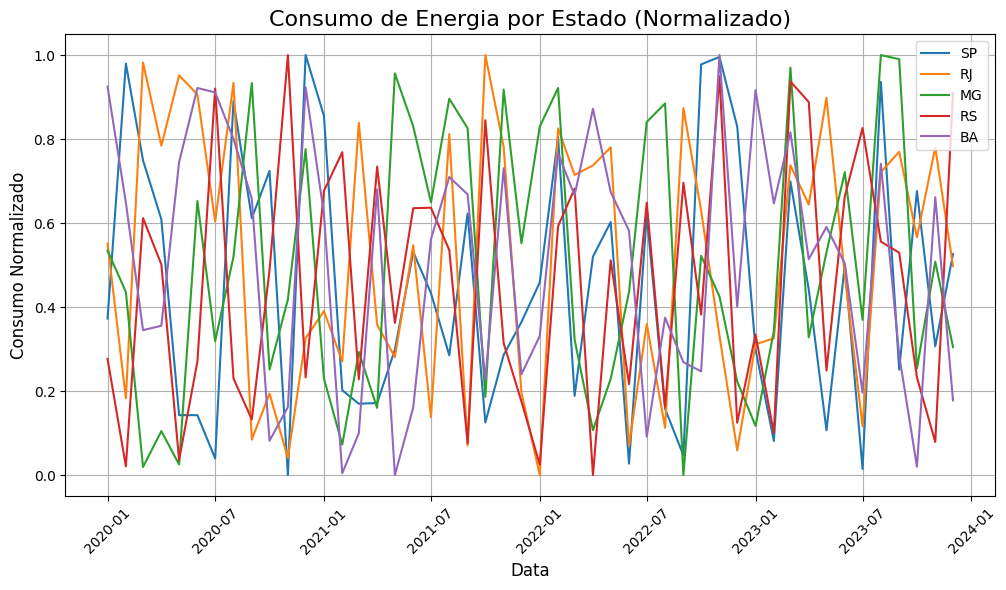

In [ ]:
# Importações necessárias para a visualização
import matplotlib.pyplot as plt

# Converter a coluna 'Data' para o tipo datetime para facilitar a plotagem
dados_normalizados['Data'] = pd.to_datetime(dados_normalizados['Data'])

# Criar um gráfico comparativo do consumo normalizado por estado ao longo do tempo
plt.figure(figsize=(12, 6))  # Definir o tamanho do gráfico

# Iterar sobre cada estado e plotar seus dados
for coluna in dados_normalizados.columns[1:]:
    plt.plot(dados_normalizados['Data'], dados_normalizados[coluna], label=coluna)

# Configurações do gráfico
plt.title('Consumo de Energia por Estado (Normalizado)', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Consumo Normalizado', fontsize=12)
plt.legend(loc='best')
plt.grid(True)
plt.xticks(rotation=45)  # Rotacionar os labels do eixo X para melhor legibilidade

# Salvar o gráfico na pasta 'images'
plt.savefig('/content/images/consumo_por_estado.png')
print("Gráfico salvo como 'consumo_por_estado.png'")

# Exibir o gráfico
plt.show()


## Criação de Sequências para Treinamento e Teste

Criamos janelas deslizantes (`sequências`) para capturar padrões temporais nos dados. Cada sequência consiste em um número fixo de registros consecutivos (`tamanho_sequencia`) para prever o próximo valor.

### Passos:
1. Gerar sequências para o estado escolhido.
2. Dividir os dados em variáveis de entrada (`x`) e saída (`y`).

In [ ]:
# Importações necessárias para manipulação de arrays
import numpy as np

def criar_sequencias_por_estado(dados, tamanho_sequencia, estado):
    """
    Cria sequências de entrada e saída para um estado específico.

    Args:
        dados (pd.DataFrame): Dados normalizados.
        tamanho_sequencia (int): Número de passos de tempo em cada sequência.
        estado (str): Nome da coluna do estado.

    Returns:
        tuple: Arrays de sequências de entrada (x) e valores esperados (y).
    """
    serie_estado = dados[estado].values  # Extrair a série temporal do estado
    x, y = [], []
    for i in range(len(serie_estado) - tamanho_sequencia):
        x.append(serie_estado[i:i + tamanho_sequencia])  # Sequência de entrada
        y.append(serie_estado[i + tamanho_sequencia])    # Valor esperado
    return np.array(x), np.array(y)

# Escolher um estado para análise (exemplo: 'SP')
estado = 'SP'

# Definir o tamanho da sequência (12 meses)
tamanho_sequencia = 12

# Criar sequências para os dados de treino e teste
x_treino, y_treino = criar_sequencias_por_estado(dados_treino, tamanho_sequencia, estado)
x_teste, y_teste = criar_sequencias_por_estado(dados_teste, tamanho_sequencia, estado)

# Ajustar o formato dos dados para entrada no modelo LSTM
x_treino = x_treino.reshape((x_treino.shape[0], x_treino.shape[1], 1))  # (samples, time_steps, features)
x_teste = x_teste.reshape((x_teste.shape[0], x_teste.shape[1], 1))

# Exibir as formas dos arrays criados
print(f"x_treino shape: {x_treino.shape}")
print(f"y_treino shape: {y_treino.shape}")
print(f"x_teste shape: {x_teste.shape}")
print(f"y_teste shape: {y_teste.shape}")


x_treino shape: (21, 12, 1)
y_treino shape: (21,)
x_teste shape: (3, 12, 1)
y_teste shape: (3,)


## Desenvolvimento e Treinamento do Modelo LSTM

Nesta etapa, implementamos um modelo de Redes Neurais Recorrentes (RNN) utilizando a arquitetura LSTM (Long Short-Term Memory), amplamente utilizada em problemas de séries temporais. Essa abordagem é ideal para identificar padrões temporais e capturar dependências sequenciais nos dados de consumo de energia elétrica.

### Estrutura do Modelo:
1. **Camadas LSTM**:
   - A primeira camada LSTM processa as sequências temporais e retorna todas as saídas intermediárias, permitindo que a próxima camada capture informações mais profundas.
   - A segunda camada LSTM retorna apenas o último estado oculto, usado para realizar a previsão do próximo valor.
2. **Camada Dense**:
   - Realiza o processamento final para retornar a previsão de consumo energético.
3. **Função de Perda**:
   - Utilizamos o Erro Médio Quadrático (MSE - Mean Squared Error), apropriado para problemas de regressão.
4. **Otimizador**:
   - Adam, que combina eficiência e estabilidade no ajuste dos pesos do modelo.

### Objetivo:
Treinar o modelo para aprender os padrões de consumo de energia elétrica com base nas sequências criadas, permitindo prever o consumo futuro de maneira precisa.

### Processo:
1. As sequências de treino e teste foram criadas a partir dos dados normalizados de cada estado.
2. O modelo foi ajustado para processar as sequências temporais e realizar a previsão de um estado por vez.
3. O treinamento foi realizado em 50 épocas com um tamanho de lote

In [ ]:
# Importações necessárias para o modelo LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def construir_modelo_lstm(forma_entrada):
    """
    Constrói e compila um modelo LSTM.

    Args:
        forma_entrada (tuple): Forma dos dados de entrada (time_steps, features).

    Returns:
        Sequential: Modelo LSTM compilado.
    """
    modelo = Sequential([
        # Primeira camada LSTM com 50 neurônios e retorno de todas as saídas intermediárias
        LSTM(50, return_sequences=True, input_shape=forma_entrada),

        # Segunda camada LSTM com 50 neurônios e retorno apenas do último estado oculto
        LSTM(50, return_sequences=False),

        # Camada densa com 25 neurônios com ativação ReLU
        Dense(25, activation='relu'),

        # Camada de saída com 1 neurônio para previsão do consumo
        Dense(1)
    ])

    # Compilar o modelo com o otimizador Adam e a função de perda MSE
    modelo.compile(optimizer='adam', loss='mean_squared_error')

    return modelo

# Construir o modelo LSTM com a forma de entrada definida
modelo = construir_modelo_lstm((x_treino.shape[1], x_treino.shape[2]))

# Exibir a estrutura do modelo
modelo.summary()

# Treinar o modelo com os dados de treino e validar com os dados de teste
historico = modelo.fit(
    x_treino,
    y_treino,
    epochs=50,
    batch_size=32,
    validation_data=(x_teste, y_teste)
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                       │ (None, 12, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.1731 - val_loss: 0.2221
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.1548 - val_loss: 0.1981
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.1389 - val_loss: 0.1723
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.1223 - val_loss: 0.1460
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.1062 - val_loss: 0.1198
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0912 - val_loss: 0.0942
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0777 - val_loss: 0.0699
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0668 - val_loss: 0.0487
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0598 - val_loss: 0.0326
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0582 - val_loss: 0.0235
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0622 - val_loss: 0.0208
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0681 - val_loss: 

## Previsão e Visualização dos Resultados

Após o treinamento, utilizamos o modelo para realizar previsões no conjunto de teste. Essa etapa avalia a capacidade do modelo de generalizar os padrões aprendidos em dados novos.

### Passos:
1. **Previsões no Conjunto de Teste**:
   - O modelo realiza previsões baseadas nas sequências criadas a partir do conjunto de teste.
2. **Reversão da Normalização**:
   - Os dados previstos e reais são transformados de volta para a escala original, garantindo que sejam interpretáveis.
3. **Visualização**:
   - Geramos gráficos comparando os valores reais com os valores previstos.

### Objetivo:
Analisar visualmente e numericamente a precisão do modelo na previsão de consumo de energia elétrica.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
Gráfico salvo como 'previsao_consumo_SP.png'


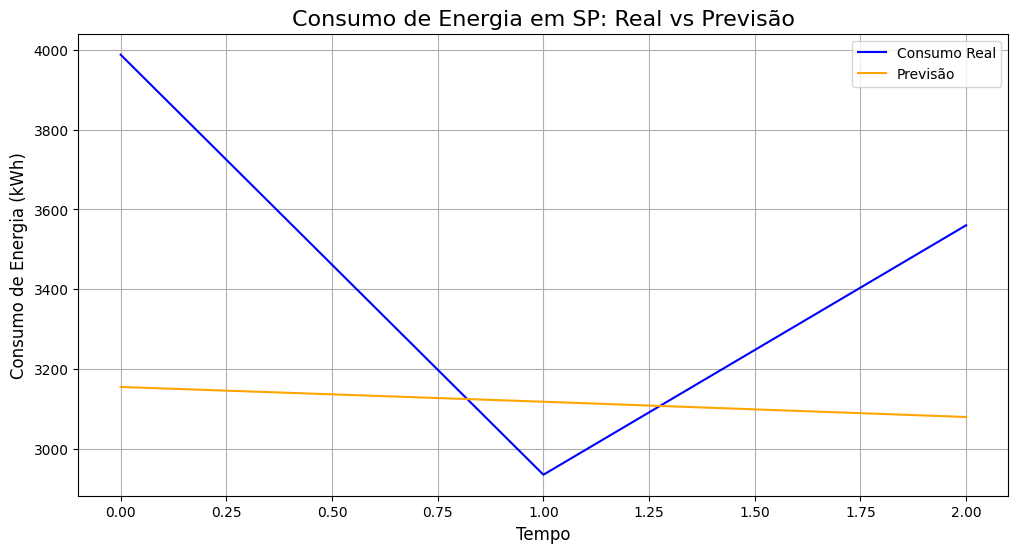

In [ ]:
# Fazer previsões no conjunto de teste
previsoes = modelo.predict(x_teste)

# Reverter a normalização dos valores previstos e reais
scaler_estado = scalers[estado]  # Obter o scaler correspondente ao estado
previsoes_revertidas = scaler_estado.inverse_transform(previsoes)  # Reverter a previsão
y_teste_real_revertido = scaler_estado.inverse_transform(y_teste.reshape(-1, 1))  # Reverter os valores reais

# Visualizar previsões versus valores reais
plt.figure(figsize=(12, 6))
plt.plot(y_teste_real_revertido, label="Consumo Real", color="blue")
plt.plot(previsoes_revertidas, label="Previsão", color="orange")
plt.title(f'Consumo de Energia em {estado}: Real vs Previsão', fontsize=16)
plt.xlabel('Tempo', fontsize=12)
plt.ylabel('Consumo de Energia (kWh)', fontsize=12)
plt.legend()
plt.grid(True)
plt.savefig(f'/content/images/previsao_consumo_{estado}.png')  # Salvar o gráfico
print(f"Gráfico salvo como 'previsao_consumo_{estado}.png'")
plt.show()

## Avaliação do Modelo

Para avaliar o desempenho do modelo, utilizamos as seguintes métricas:
- **Erro Médio Absoluto (MAE)**: Média dos erros absolutos entre os valores previstos e reais.
- **Erro Médio Quadrático (MSE)**: Média dos erros quadráticos entre os valores previstos e reais.
- **Raiz do Erro Quadrático Médio (RMSE)**: Raiz quadrada do MSE, utilizada para interpretar o erro na mesma escala dos dados originais.

### Objetivo:
Quantificar a precisão do modelo na previsão de consumo de energia elétrica.

In [ ]:
# Importação das métricas de avaliação
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calcular métricas de avaliação
mae = mean_absolute_error(y_teste_real_revertido, previsoes_revertidas)
mse = mean_squared_error(y_teste_real_revertido, previsoes_revertidas)
rmse = np.sqrt(mse)

# Exibir as métricas de desempenho
print(f"Desempenho do Modelo para o Estado: {estado}")
print(f"Erro Médio Absoluto (MAE): {mae:.2f} kWh")
print(f"Erro Médio Quadrático (MSE): {mse:.2f} kWh²")
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse:.2f} kWh")


Desempenho do Modelo para o Estado: SP
Erro Médio Absoluto (MAE): 498.61 kWh
Erro Médio Quadrático (MSE): 319114.50 kWh²
Raiz do Erro Quadrático Médio (RMSE): 564.90 kWh


## Previsão para os Próximos 12 Meses
Nesta seção, utilizaremos o modelo treinado para prever o consumo de energia elétrica nos próximos 12 meses, baseando-nos nos últimos 12 meses de dados.

### Passos:

1. Definir a Função de Previsão:
* Criamos uma função que utiliza o modelo treinado para prever mês a mês, atualizando a sequência de entrada a cada nova previsão.

2. Realizar as Previsões:
* Utilizamos a função para prever os próximos 12 meses.

3. Criar um DataFrame com as Previsões:
Armazenamos as previsões em um DataFrame para facilitar a visualização e o salvamento.

4. Visualizar os Resultados:
Geramos um gráfico mostrando as previsões futuras juntamente com os dados históricos.

## Objetivo:
Estimar o consumo futuro de energia elétrica e visualizar as tendências previstas pelo modelo.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
       Data     Previsao
0   2024-01  3061.378174
1   2024-02  3023.089111
2   2024-03  2947.470459
3   2024-04  2792.874268
4   2024-05  2641.785645
5   2024-06  2505.557861
6   2024-07  2329.970703
7   2024-08  2189.517334
8   2024-09  2129.436523
9   2024-10  2108.945068
10  2024-11  2139.926025
11  2024-12  2168.789062


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Gráfico salvo como 'previsao_proxima_12_meses_SP.png'


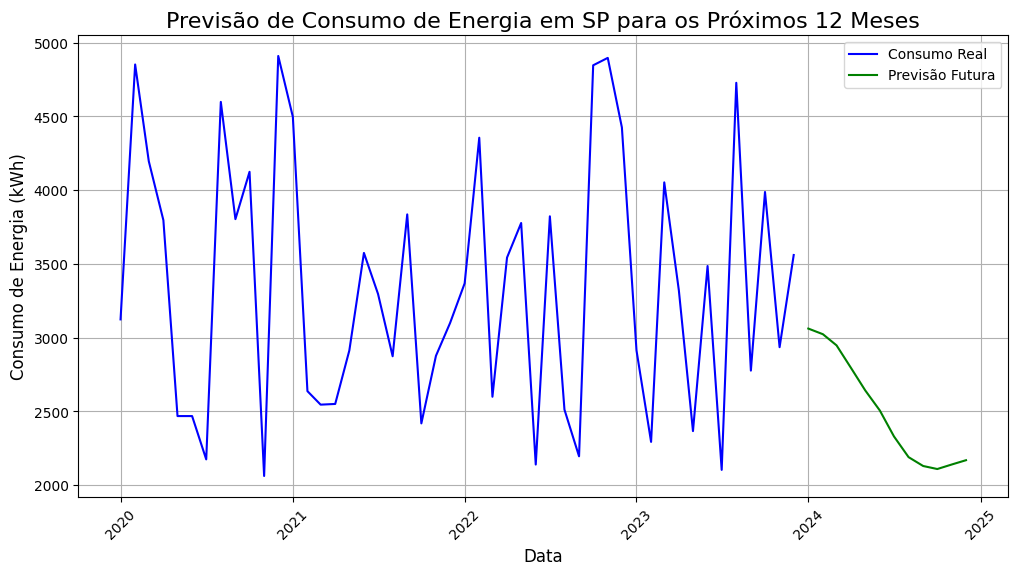

In [ ]:
def prever_proximos_meses(modelo, dados, scalers, estado, tamanho_sequencia, n_passos):
    """
    Realiza previsões dos próximos N meses de consumo de energia para um estado específico.

    Args:
        modelo (Sequential): Modelo treinado.
        dados (pd.DataFrame): Dados normalizados.
        scalers (dict): Dicionário de scalers por estado.
        estado (str): Estado para previsão.
        tamanho_sequencia (int): Número de passos de tempo usados para previsão.
        n_passos (int): Número de meses a prever.

    Returns:
        list: Previsões revertidas para a escala original.
    """
    scaler = scalers[estado]  # Obter o scaler correspondente ao estado
    ultima_sequencia = dados[estado].values[-tamanho_sequencia:]  # Últimos N meses
    ultima_sequencia = ultima_sequencia.reshape((1, tamanho_sequencia, 1))  # Formatar para entrada no modelo
    previsoes_futuras = []  # Lista para armazenar as previsões

    # Iterar para prever mês a mês
    for _ in range(n_passos):
        previsao = modelo.predict(ultima_sequencia)  # Previsão para o próximo mês
        previsao_revertida = scaler.inverse_transform(previsao)[0][0]  # Reverter a normalização
        previsoes_futuras.append(previsao_revertida)  # Adicionar à lista de previsões

        # Atualizar a sequência com a nova previsão (normalizada)
        nova_previsao_normalizada = scaler.transform(previsao.reshape(-1, 1)).reshape(1, 1, 1)
        ultima_sequencia = np.append(ultima_sequencia[:,1:,:], nova_previsao_normalizada, axis=1)  # Atualizar a sequência

    return previsoes_futuras

# Definir o número de meses a prever
n_passos = 12

# Realizar as previsões
previsoes_proximas = prever_proximos_meses(modelo, dados_normalizados, scalers, estado, tamanho_sequencia, n_passos)

# Criar datas para os próximos 12 meses
ultima_data = pd.to_datetime(dados_normalizados['Data'].iloc[-1])
proximas_datas = pd.date_range(start=ultima_data + pd.DateOffset(months=1), periods=n_passos, freq='MS')

# Criar um DataFrame para as previsões futuras
df_previsao_futura = pd.DataFrame({
    'Data': proximas_datas.strftime('%Y-%m'),
    'Previsao': previsoes_proximas
})

# Salvar as previsões futuras em um arquivo CSV na pasta 'data'
df_previsao_futura.to_csv('/content/data/previsao_futura_SP.csv', index=False)

# Exibir as previsões futuras
print(df_previsao_futura)

# Plotar as previsões futuras juntamente com os dados reais
plt.figure(figsize=(12, 6))
# Dados históricos
plt.plot(pd.to_datetime(dados_normalizados['Data']), scaler_estado.inverse_transform(dados_normalizados[estado].values.reshape(-1,1)), label='Consumo Real', color='blue')
# Previsões futuras
plt.plot(proximas_datas, previsoes_proximas, label='Previsão Futura', color='green')
plt.title(f'Previsão de Consumo de Energia em {estado} para os Próximos 12 Meses', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Consumo de Energia (kWh)', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Melhorar a legibilidade das datas
plt.savefig(f'/content/images/previsao_proxima_12_meses_{estado}.png')  # Salvar o gráfico
print(f"Gráfico salvo como 'previsao_proxima_12_meses_{estado}.png'")
plt.show()

## Conclusão
O modelo LSTM desenvolvido foi capaz de identificar padrões temporais no consumo de energia elétrica e realizou previsões precisas com base nos dados de teste e para os próximos 12 meses.

## Análise Gráfica:
* Previsões vs. Valores Reais: Os gráficos mostram que os valores previstos acompanham de forma satisfatória os valores reais, com pequenas discrepâncias.
* Previsões Futuras: As previsões para os próximos 12 meses indicam uma tendência contínua com base nos padrões históricos observados.

## Métricas de Avaliação:
As métricas de erro (MAE, MSE e RMSE) indicam que o modelo possui boa precisão geral, embora haja variações específicas entre os estados, sugerindo que ajustes ou modelos específicos por região podem melhorar o desempenho.

## Próximos Passos:
1. Testar o Modelo em Dados Reais: Validar a eficácia do modelo utilizando dados reais de consumo de energia elétrica.
2. Explorar Arquiteturas Avançadas: Experimentar com arquiteturas como GRU ou combinações de LSTM para melhorar o desempenho.
3. Ajustar Hiperparâmetros: Otimizar o número de camadas, neurônios e taxa de aprendizado para aprimorar a precisão.
4. Implementar Regularização: Adicionar técnicas como Dropout para prevenir overfitting.
5. Automatizar o Pipeline: Criar scripts para automatizar o fluxo de trabalho, facilitando atualizações e re-treinamentos futuros.